<a href="https://colab.research.google.com/github/peylix/CNN-RAG/blob/main/afrn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shawon10_ckplus_path = kagglehub.dataset_download('shawon10/ckplus')

print('Data source import complete.')


**load libraries**

In [ ]:
# # =========================
# # 0) 导入与全局设置（与手动训练一致）
# # =========================
# import os, random, math, time, json
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import layers, models, Input, regularizers
# from tensorflow.keras.layers import (
#     Conv2D, Dense, BatchNormalization, Dropout, MaxPooling2D,
#     GlobalAveragePooling2D, GlobalMaxPooling2D, UpSampling2D, Reshape
# )
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# import matplotlib.pyplot as plt
# import pandas as pd
# from collections import Counter

# # -------- 和手动对齐的超参 --------
# IMAGE_SIZE = 48
# BATCH_SIZE = 64
# N_CLASSES  = 7
# EPOCHS     = 200
# REPEATS    = 3
# SEEDS      = [42, 123, 2025]
# BASE_LR    = 1e-4
# CLIPNORM   = 1.0

# # !!! 修改为你的数据集根目录（必须包含 train/ 与 val/）
# # !!! 修改为你的数据集根目录（拆分后包含 train/ 与 val/）
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# # 原始数据目录（未拆分）
# import shutil, os

# # 复制数据到 Colab 本地
# src_dir = "/content/drive/MyDrive/ck+/CK+48"
# local_src = "/content/CK+48"
# if not os.path.exists(local_src):
#     shutil.copytree(src_dir, local_src)
# print("数据已复制到本地：", local_src)

# # 在本地创建可写的拆分目录
# DATASET_PATH = "/content/CK48_split"
# os.makedirs(DATASET_PATH, exist_ok=True)

# # 开始拆分
# import random
# classes = os.listdir(local_src)
# for cls in classes:
#     cls_path = os.path.join(local_src, cls)
#     if not os.path.isdir(cls_path):
#         continue
#     images = os.listdir(cls_path)
#     random.shuffle(images)

#     split_idx = int(0.8 * len(images))
#     train_imgs, val_imgs = images[:split_idx], images[split_idx:]

#     for split, img_list in [("train", train_imgs), ("val", val_imgs)]:
#         split_dir = os.path.join(DATASET_PATH, split, cls)
#         os.makedirs(split_dir, exist_ok=True)
#         for img in img_list:
#             shutil.copy(os.path.join(cls_path, img), os.path.join(split_dir, img))

# print("数据集已在本地 /content 拆分完成！", DATASET_PATH)





# # 复现性
# def set_seed(seed=42, deterministic_gpu=False):
#     import os
#     os.environ["PYTHONHASHSEED"] = str(seed)
#     random.seed(seed)
#     np.random.seed(seed)
#     tf.random.set_seed(seed)
#     if deterministic_gpu:
#         os.environ["TF_DETERMINISTIC_OPS"] = "1"

# set_seed(42, deterministic_gpu=False)

# # =========================
# # 1) 数据集：与手动训练同等管线
# # =========================
# def build_datasets(data_dir, image_size=48, batch_size=64):
#     from tensorflow.keras.utils import image_dataset_from_directory

#     resize_and_rescale = tf.keras.Sequential([
#         layers.Resizing(image_size, image_size),
#         layers.Rescaling(1./255)
#     ])

#     data_augmentation = tf.keras.Sequential([
#         layers.RandomFlip("horizontal_and_vertical"),
#         layers.RandomRotation(0.2),
#     ])

#     train = image_dataset_from_directory(
#         os.path.join(data_dir, "train"),
#         image_size=(image_size, image_size),
#         batch_size=batch_size,
#         label_mode="int",
#         shuffle=True
#     )
#     # 归一化 + 只对训练集做增强（顺序与手动一致）
#     train = train.map(lambda x,y: (resize_and_rescale(x), y))
#     train = train.map(lambda x,y: (data_augmentation(x, training=True), y))
#     train = train.prefetch(tf.data.AUTOTUNE)

#     val = image_dataset_from_directory(
#         os.path.join(data_dir, "val"),
#         image_size=(image_size, image_size),
#         batch_size=batch_size,
#         label_mode="int",
#         shuffle=False
#     )
#     val = val.map(lambda x,y: (resize_and_rescale(x), y))
#     val = val.prefetch(tf.data.AUTOTUNE)

#     return train, val

# train_ds, val_ds = build_datasets(DATASET_PATH, IMAGE_SIZE, BATCH_SIZE)


# # 自动计算 class weights（和手动一致的效果；若你已有字典可直接替换）
# def compute_class_weights_from_dataset(ds, n_classes):
#     counts = np.zeros(n_classes, dtype=np.int64)
#     for _, y in ds.unbatch():
#         counts[int(y.numpy())] += 1
#     total = counts.sum()
#     # 常用“总样本 / (num_classes * class_count)”的定义
#     weights = {i: float(total / (n_classes * max(1, counts[i]))) for i in range(n_classes)}
#     return weights, counts

# CLASS_WEIGHTS, CLASS_COUNTS = compute_class_weights_from_dataset(train_ds, N_CLASSES)
# print("Class counts:", CLASS_COUNTS)
# print("Class weights:", CLASS_WEIGHTS)

# # =========================
# # 2) 模块：AFR 与 PFF（与你原代码一致 + 可开关）
# # =========================
# def adaptive_feature_recalibration(x, reduction_ratio=16, use_gap=True, use_gmp=True):
#     """
#     自适应特征重标定（SE风格）。
#     可用 use_gap/use_gmp 开关做 w/o GAP / w/o GMP 的消融。
#     """
#     c = x.shape[-1]
#     branches = []
#     if use_gap:
#         gap = GlobalAveragePooling2D()(x)
#         branches.append(gap)
#     if use_gmp:
#         gmp = GlobalMaxPooling2D()(x)
#         branches.append(gmp)
#     if not branches:  # 两个都关 => 等价于 w/o AFR
#         return x

#     shared1 = Dense(max(c // reduction_ratio, 1), activation='relu')
#     shared2 = Dense(c, activation='sigmoid')

#     att_vecs = [shared2(shared1(b)) for b in branches]
#     att = layers.add(att_vecs) if len(att_vecs) > 1 else att_vecs[0]
#     att = Reshape((1, 1, c))(att)
#     return layers.multiply([x, att])

# def progressive_feature_fusion_fixed(feature1, feature2, use_attention=True):
#     """
#     渐进式特征融合：对齐通道，上采样高层特征到低层尺度，再相加；
#     可选通道注意力加权。
#     """
#     ch1, ch2 = feature1.shape[-1], feature2.shape[-1]
#     C = int(max(ch1, ch2))
#     if ch1 != C:
#         feature1 = Conv2D(C, (1,1), activation='relu')(feature1)
#     if ch2 != C:
#         feature2 = Conv2D(C, (1,1), activation='relu')(feature2)

#     feature2_up = UpSampling2D(size=(2,2))(feature2)
#     merged = layers.add([feature1, feature2_up])

#     if not use_attention:
#         return merged

#     w = GlobalAveragePooling2D()(merged)
#     w = Dense(C, activation='sigmoid')(w)
#     w = Reshape((1,1,C))(w)
#     return layers.multiply([merged, w])

# # =========================
# # 3) 模型工厂（与你手动一致的主干 + 可配置消融）
# # =========================
# def build_model(cfg):
#     """
#     cfg 支持字段：
#       - baseline: 仅最简CNN基线
#       - use_afr: 是否在各stage使用AFR
#       - afr_gap / afr_gmp: AFR内部是否启用 GAP / GMP 分支
#       - use_pff: 是否启用PFF融合
#       - pff_attention: PFF中是否使用通道注意力
#       - only_afr: 仅AFR（不做PFF）
#       - only_pff: 仅PFF（不做AFR）
#     """
#     inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
#     x = inputs

#     # Baseline
#     if cfg.get("baseline", False):
#         x = Conv2D(32, 3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
#         x = MaxPooling2D()(x)
#         x = Conv2D(64, 3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
#         x = MaxPooling2D()(x)
#         x = Conv2D(128,3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
#         x = GlobalAveragePooling2D()(x)
#         x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-2))(x)
#         x = Dropout(0.4)(x)
#         out = Dense(N_CLASSES, activation='softmax')(x)
#         return models.Model(inputs, out)

#     # Stage 1
#     x1 = Conv2D(32, (3,3), activation='relu', padding='same')(x)
#     x1 = BatchNormalization()(x1)
#     if (cfg.get("use_afr", True) or cfg.get("only_afr", False)) and not cfg.get("only_pff", False):
#         x1 = adaptive_feature_recalibration(
#             x1, use_gap=cfg.get("afr_gap", True), use_gmp=cfg.get("afr_gmp", True)
#         )
#     x1p = MaxPooling2D()(x1); x1p = Dropout(0.2)(x1p)

#     # Stage 2
#     x2 = Conv2D(64, (3,3), activation='relu', padding='same')(x1p)
#     x2 = BatchNormalization()(x2)
#     if (cfg.get("use_afr", True) or cfg.get("only_afr", False)) and not cfg.get("only_pff", False):
#         x2 = adaptive_feature_recalibration(
#             x2, use_gap=cfg.get("afr_gap", True), use_gmp=cfg.get("afr_gmp", True)
#         )
#     x2p = MaxPooling2D()(x2); x2p = Dropout(0.25)(x2p)

#     # Stage 3
#     x3 = Conv2D(128, (3,3), activation='relu', padding='same')(x2p)
#     x3 = BatchNormalization()(x3)
#     if (cfg.get("use_afr", True) or cfg.get("only_afr", False)) and not cfg.get("only_pff", False):
#         x3 = adaptive_feature_recalibration(
#             x3, use_gap=cfg.get("afr_gap", True), use_gmp=cfg.get("afr_gmp", True)
#         )

#     # PFF
#     if cfg.get("only_afr", False):
#         feat = x3
#     elif cfg.get("only_pff", False):
#         feat = progressive_feature_fusion_fixed(x2, x3, use_attention=cfg.get("pff_attention", True))
#     else:
#         if cfg.get("use_pff", True):
#             feat = progressive_feature_fusion_fixed(x2, x3, use_attention=cfg.get("pff_attention", True))
#         else:
#             feat = x3

#     feat = Dropout(0.3)(feat)

#     x = GlobalAveragePooling2D()(feat)
#     x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-2))(x)
#     x = Dropout(0.4)(x)
#     out = Dense(N_CLASSES, activation='softmax')(x)
#     return models.Model(inputs, out)

# # =========================
# # 4) 训练一次（与手动一致的优化器与回调）
# # =========================
# def train_and_eval_once(cfg, seed):
#     tf.keras.backend.clear_session()
#     set_seed(seed)

#     model = build_model(cfg)
#     optimizer = Adam(learning_rate=BASE_LR, beta_1=0.9, beta_2=0.999, epsilon=1e-8, clipnorm=CLIPNORM)
#     model.compile(
#         optimizer=optimizer,
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#         metrics=['accuracy']
#     )
#     callbacks = [
#         ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-8, verbose=0),
#         EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
#     ]
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=EPOCHS,
#         verbose=0,
#         callbacks=callbacks,
#         class_weight=CLASS_WEIGHTS
#     )
#     loss, acc = model.evaluate(val_ds, verbose=0)
#     return acc, loss

# # =========================
# # 5) 十种配置（与图例一致）
# # =========================
# CONFIGS = [
#     ("Baseline CNN",      dict(baseline=True)),
#     ("AFRN (Ours)",       dict(use_afr=True,  use_pff=True,  afr_gap=True,  afr_gmp=True,  pff_attention=True)),
#     ("w/o AFR",           dict(use_afr=False, use_pff=True,  afr_gap=False, afr_gmp=False, pff_attention=True)),
#     ("w/o PFF",           dict(use_afr=True,  use_pff=False, afr_gap=True,  afr_gmp=True,  pff_attention=False)),
#     ("w/o GAP",           dict(use_afr=True,  use_pff=True,  afr_gap=False, afr_gmp=True,  pff_attention=True)),
#     ("w/o GMP",           dict(use_afr=True,  use_pff=True,  afr_gap=True,  afr_gmp=False, pff_attention=True)),
#     ("w/o PFF Attention", dict(use_afr=True,  use_pff=True,  afr_gap=True,  afr_gmp=True,  pff_attention=False)),
#     ("Only AFR",          dict(only_afr=True, use_afr=True,  use_pff=False, afr_gap=True,  afr_gmp=True)),
#     ("Only PFF",          dict(only_pff=True, use_afr=False, use_pff=True,  pff_attention=True)),
#     ("w/o GAP&GMP",       dict(use_afr=True,  use_pff=True,  afr_gap=False, afr_gmp=False, pff_attention=True)),
# ]
# assert len(CONFIGS) == 10

# # =========================
# # 6) 跑实验（10 配置 × 3 种子）
# # =========================
# results = {}
# rows = []
# for name, cfg in CONFIGS:
#     accs, losses = [], []
#     for s in SEEDS:
#         acc, loss = train_and_eval_once(cfg, seed=s)
#         accs.append(acc); losses.append(loss)
#         print(f"[{name}] seed={s}  val_acc={acc:.4f}  val_loss={loss:.4f}")
#         rows.append({"config": name, "seed": s, "val_acc": acc, "val_loss": loss})
#     results[name] = {
#         "accs": accs,
#         "losses": losses,
#         "acc_mean": float(np.mean(accs)),
#         "acc_std":  float(np.std(accs)),
#         "loss_mean": float(np.mean(losses)),
#         "loss_std":  float(np.std(losses)),
#     }

# # 保存明细结果
# os.makedirs("./figs", exist_ok=True)
# df = pd.DataFrame(rows)
# df.to_csv("./figs/results.csv", index=False)
# print("\n明细已保存到 ./figs/results.csv")

# # 打印汇总
# print("\n=== Summary ===")
# for k,v in results.items():
#     print(f"{k:20s}  acc={v['acc_mean']:.4f}±{v['acc_std']:.4f}   loss={v['loss_mean']:.4f}±{v['loss_std']:.4f}")

# # =========================
# # 7) 画图（与示例相同风格：两张误差棒柱状图）
# # =========================
# labels     = [k for k,_ in CONFIGS]
# acc_means  = [results[k]["acc_mean"]  for k,_ in CONFIGS]
# acc_stds   = [results[k]["acc_std"]   for k,_ in CONFIGS]
# loss_means = [results[k]["loss_mean"] for k,_ in CONFIGS]
# loss_stds  = [results[k]["loss_std"]  for k,_ in CONFIGS]

# plt.figure(figsize=(18,6))

# # 左：Validation Accuracy
# plt.subplot(1,2,1)
# plt.bar(labels, acc_means, yerr=acc_stds, capsize=5, alpha=0.7)
# plt.ylabel("Validation Accuracy")
# plt.title("Ablation Study: Validation Accuracy")
# plt.xticks(rotation=20, ha='right')
# plt.ylim(0, max(0.01, max(acc_means)+max(acc_stds)*1.3))

# # 右：Validation Loss
# plt.subplot(1,2,2)
# plt.bar(labels, loss_means, yerr=loss_stds, capsize=5, alpha=0.7)
# plt.ylabel("Validation Loss")
# plt.title("Ablation Study: Validation Loss")
# plt.xticks(rotation=20, ha='right')
# plt.ylim(0, max(0.01, max(loss_means)+max(loss_stds)*1.3))

# plt.tight_layout()
# save_path = "./figs/ablation_results.png"
# plt.savefig(save_path, dpi=300)
# plt.show()
# print(f"图像已保存到: {save_path}")


In [ ]:
import numpy as np
import pandas as pd
import cv2
import glob as gb
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 48
CHANNELS=3

In [ ]:
# Path to dataset
from google.colab import drive
drive.mount('/content/drive')
DATASET_PATH = "/content/drive/MyDrive/ck+/CK+48"

**load data set**

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    label_mode='int',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

In [ ]:
class_names = dataset.class_names
class_names

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

split into train validate and test

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

In [ ]:
len(val_ds)

In [ ]:
len(test_ds)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Collect all labels from the training dataset
labels_list = []

for images, labels in train_ds:
    labels_list.extend(labels.numpy())

labels_array = np.array(labels_list)

# Count the number of samples for each class
counts = np.bincount(labels_array)

plt.figure(figsize=(8, 6))
plt.bar(class_names, counts, color='purple')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Distribution of training data by label')
plt.xticks(rotation=45)  # Rotate class names for better readability
plt.show()


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_array),
    y=labels_array
)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

**Model** **architecture**

Data scaling, normalization

In [ ]:
from tensorflow.keras import layers, models

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])


Data augmentaion

In [ ]:

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
#applying augmentation
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# TensorFlow和Keras相关导入
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.layers import (
    Conv2D, Dense, BatchNormalization, Dropout, MaxPooling2D,
    GlobalAveragePooling2D, GlobalMaxPooling2D, UpSampling2D,
    Reshape, add, multiply
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

def adaptive_feature_recalibration(x, reduction_ratio=16):
    """自适应特征重标定模块 - 你的创新点"""
    channel = x.shape[-1]

    # 全局上下文提取
    gap = layers.GlobalAveragePooling2D()(x)
    gmp = layers.GlobalMaxPooling2D()(x)

    # 自适应权重生成
    shared_dense1 = layers.Dense(channel // reduction_ratio, activation='relu')
    shared_dense2 = layers.Dense(channel, activation='sigmoid')

    gap_out = shared_dense2(shared_dense1(gap))
    gmp_out = shared_dense2(shared_dense1(gmp))

    # 自适应融合
    attention = layers.add([gap_out, gmp_out])
    attention = layers.Reshape((1, 1, channel))(attention)

    return layers.multiply([x, attention])

def progressive_feature_fusion_fixed(feature1, feature2):
    """修复后的渐进式特征融合 - 只融合两个特征图"""
    # 通道对齐 - 统一到较大的通道数
    channels1 = feature1.shape[-1]
    channels2 = feature2.shape[-1]
    target_channels = max(channels1, channels2)

    if channels1 != target_channels:
        feature1 = layers.Conv2D(target_channels, (1, 1), activation='relu')(feature1)
    if channels2 != target_channels:
        feature2 = layers.Conv2D(target_channels, (1, 1), activation='relu')(feature2)

    # 尺寸对齐 - 将feature1上采样到feature2的尺寸（假设feature2尺寸更大）
    # 由于feature2是在feature1之后经过池化的，所以feature1需要下采样或feature2需要上采样
    # 这里我们简化处理，直接对feature2进行上采样
    feature2_upsampled = layers.UpSampling2D(size=(2, 2))(feature2)

    # 自适应权重生成
    combined = layers.add([feature1, feature2_upsampled])
    attention_weights = layers.GlobalAveragePooling2D()(combined)
    attention_weights = layers.Dense(target_channels, activation='sigmoid')(attention_weights)
    attention_weights = layers.Reshape((1, 1, target_channels))(attention_weights)

    # 加权融合
    fused = layers.multiply([combined, attention_weights])
    return fused

# 简化版的AFRN网络
def create_afrn_model_fixed(input_shape, n_classes, resize_and_rescale=None, use_afr=True):
    input_layer = Input(shape=input_shape)

    # 预处理
    x = resize_and_rescale(input_layer) if resize_and_rescale is not None else input_layer

    # Stage 1
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x1 = layers.BatchNormalization()(x1)
    if use_afr:
        x1 = adaptive_feature_recalibration(x1)   # AFR 开
    # w/o AFR: 不做重标定，直接进入下游
    x1_pooled = layers.MaxPooling2D((2, 2))(x1)
    x1_pooled = layers.Dropout(0.2)(x1_pooled)

    # Stage 2
    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1_pooled)
    x2 = layers.BatchNormalization()(x2)
    if use_afr:
        x2 = adaptive_feature_recalibration(x2)   # AFR 开
    x2_pooled = layers.MaxPooling2D((2, 2))(x2)
    x2_pooled = layers.Dropout(0.25)(x2_pooled)

    # Stage 3
    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x2_pooled)
    x3 = layers.BatchNormalization()(x3)
    if use_afr:
        x3 = adaptive_feature_recalibration(x3)   # AFR 开

    # 渐进式特征融合：融合 stage2 和 stage3（注意，这里使用的是 x2/x3，而不是 pooled 版本）
    fused = progressive_feature_fusion_fixed(x2, x3)
    fused = layers.Dropout(0.3)(fused)

    # 分类头
    x = layers.GlobalAveragePooling2D()(fused)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(n_classes, activation='softmax')(x)

    return models.Model(inputs=input_layer, outputs=output)

# —— 创建模型：w/o AFR —— 关键是 use_afr=False
model = create_afrn_model_fixed((48, 48, 3), 7, resize_and_rescale=None, use_afr=False)

# 优化器和回调设置
optimizer = Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8,
    clipnorm=1.0
)

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-8,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
]

# 编译模型
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 打印模型结构
model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=200,
    class_weight=class_weights_dict
)


In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(200), acc, label='Training Accuracy')
plt.plot(range(200), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(200), loss, label='Training Loss')
plt.plot(range(200), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to the image
img_path = "/content/drive/MyDrive/ck+/CK+48/anger/S010_004_00000017.png"

# Load and preprocess the image
img = cv2.imread(str(img_path))
img = cv2.resize(img, (48, 48))
img_input = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict
pred = model.predict(img_input)
predicted_class_idx = np.argmax(pred)
confidence = round(np.max(pred) * 100, 2)

class_names = ["angry", "neutral", "disgust", "afraid", "happy", "sad", "surprised"]
predicted_class = class_names[predicted_class_idx]


# Show image with prediction
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_class}, Confidence: {confidence:.2f}")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(100,32))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()


In [ ]:
model.save('Emotions.h5')

In [ ]:
!pip install gradio

In [ ]:
import cv2
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained model
# model = load_model("path_to_your_model.h5")  # Uncomment and specify your model if needed

# Class names
class_names = ["angry", "neutral", "disgust", "afraid", "happy", "sad", "surprised"]

# Prediction function
def predict_emotion(image):
    # Convert image to OpenCV format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    img = cv2.resize(image, (256, 256))
    img_input = np.expand_dims(img, axis=0)

    # Prediction
    pred = model.predict(img_input)
    predicted_class_idx = np.argmax(pred)
    confidence = round(np.max(pred) * 100, 2)
    predicted_class = class_names[predicted_class_idx]

    # Output string
    result = f"Predicted: {predicted_class}, Confidence: {confidence:.2f}%"
    return result

# Gradio interface
interface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Image(type="numpy", label="Upload a Face Image"),
    outputs=gr.Textbox(label="Prediction"),
    title="Facial Emotion Recognition",
    description="Upload a face image to see the predicted emotion and confidence score."
)

# Launch the interface
interface.launch()


[Ablation] Class counts: [104  41 139  65 172  67 180]
[Ablation] Class weights: {0: 1.054945054945055, 1: 2.6759581881533103, 2: 0.789311408016444, 3: 1.687912087912088, 4: 0.6378737541528239, 5: 1.6375266524520256, 6: 0.6095238095238096}

开始消融实验 (8 配置 × 3 种子)...

[1/8] 测试配置: AFRN (Baseline)
----------------------------------------
  种子 42 训练中... 完成! val_acc=0.3750, val_loss=2.1369, epochs=78, 用时=48.2秒
  种子 123 训练中... 完成! val_acc=0.4062, val_loss=1.9670, epochs=104, 用时=58.4秒
  种子 2025 训练中... 完成! val_acc=0.5208, val_loss=1.6201, epochs=126, 用时=67.1秒
  汇总: acc=0.4340±0.0627, loss=1.9080±0.2151, avg_epochs=102.7

[2/8] 测试配置: w/o AFR
----------------------------------------
  种子 42 训练中... 完成! val_acc=0.5000, val_loss=1.7035, epochs=124, 用时=61.6秒
  种子 123 训练中... 完成! val_acc=0.4688, val_loss=1.7628, epochs=120, 用时=60.1秒
  种子 2025 训练中... 完成! val_acc=0.5312, val_loss=1.7827, epochs=117, 用时=59.1秒
  汇总: acc=0.5000±0.0255, loss=1.7497±0.0337, avg_epochs=120.3

[3/8] 测试配置: w/o PFF
---------------

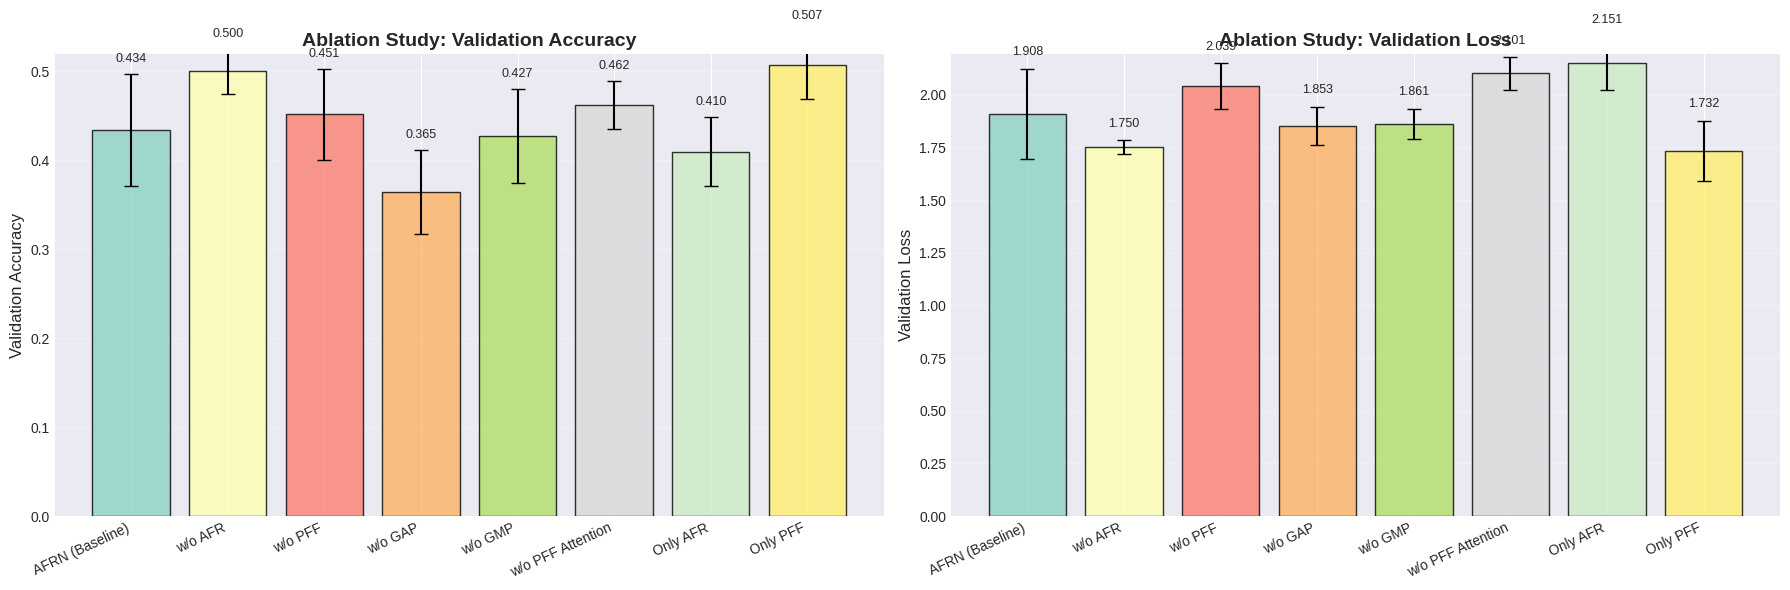

图像已保存: ./figs/ablation_results_8cfg.png


In [40]:
# ===== 消融实验主程序（AFRN / PFF 及细粒度） =====
import os, random, time, json, gc
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.layers import (
    Conv2D, Dense, BatchNormalization, Dropout, MaxPooling2D,
    GlobalAveragePooling2D, GlobalMaxPooling2D, UpSampling2D, Reshape
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt

# 复用前文的常量
IMAGE_SIZE = 48
N_CLASSES = 7
BASE_LR = 1e-4
CLIPNORM = 1.0
EPOCHS = 200
SEEDS = [42, 123, 2025]

# 固定性设置
def set_seed(seed=42, deterministic_gpu=False):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    if deterministic_gpu:
        os.environ["TF_DETERMINISTIC_OPS"] = "1"

# 轻量的 class weight 计算：直接用已存在的 train_ds
def compute_class_weights_from_dataset(ds, n_classes):
    counts = np.zeros(n_classes, dtype=np.int64)
    for _, y in ds.unbatch():
        counts[int(y.numpy())] += 1
    total = counts.sum()
    weights = {i: float(total / (n_classes * max(1, counts[i]))) for i in range(n_classes)}
    return weights, counts

CLASS_WEIGHTS, CLASS_COUNTS = compute_class_weights_from_dataset(train_ds, N_CLASSES)
print("[Ablation] Class counts:", CLASS_COUNTS)
print("[Ablation] Class weights:", CLASS_WEIGHTS)

# —— 模块实现（支持开关）——

def adaptive_feature_recalibration(x, reduction_ratio=16, use_gap=True, use_gmp=True):
    channel = x.shape[-1]
    branches = []
    if use_gap:
        gap = GlobalAveragePooling2D()(x)
        branches.append(gap)
    if use_gmp:
        gmp = GlobalMaxPooling2D()(x)
        branches.append(gmp)
    if len(branches) == 0:
        # 默认启用 GAP 以保持结构稳定
        gap = GlobalAveragePooling2D()(x)
        branches.append(gap)
    shared1 = Dense(max(channel // reduction_ratio, 1), activation='relu')
    shared2 = Dense(channel, activation='sigmoid')
    att_vecs = [shared2(shared1(b)) for b in branches]
    att = layers.add(att_vecs) if len(att_vecs) > 1 else att_vecs[0]
    att = Reshape((1, 1, channel))(att)
    return layers.multiply([x, att])


def progressive_feature_fusion_fixed(feature1, feature2, use_attention=True):
    ch1, ch2 = feature1.shape[-1], feature2.shape[-1]
    C = int(max(ch1, ch2))
    if ch1 != C:
        feature1 = Conv2D(C, (1, 1), activation='relu')(feature1)
    if ch2 != C:
        feature2 = Conv2D(C, (1, 1), activation='relu')(feature2)
    feature2_up = UpSampling2D(size=(2, 2))(feature2)
    merged = layers.add([feature1, feature2_up])
    if not use_attention:
        return merged
    w = GlobalAveragePooling2D()(merged)
    w = Dense(C, activation='sigmoid')(w)
    w = Reshape((1, 1, C))(w)
    return layers.multiply([merged, w])


def build_model(cfg):
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = inputs

    # Baseline 简单 CNN
    if cfg.get("baseline", False):
        x = Conv2D(32, 3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
        x = MaxPooling2D()(x)
        x = Conv2D(64, 3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
        x = MaxPooling2D()(x)
        x = Conv2D(128, 3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
        x = GlobalAveragePooling2D()(x)
        x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-2))(x)
        x = Dropout(0.4)(x)
        out = Dense(N_CLASSES, activation='softmax')(x)
        return models.Model(inputs, out)

    # 组合开关
    if cfg.get("only_afr", False):
        use_afr, use_pff = True, False
    elif cfg.get("only_pff", False):
        use_afr, use_pff = False, True
    else:
        use_afr = cfg.get("use_afr", True)
        use_pff = cfg.get("use_pff", True)

    afr_gap = cfg.get("afr_gap", True)
    afr_gmp = cfg.get("afr_gmp", True)
    pff_attention = cfg.get("pff_attention", True)

    # Stage 1
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x1 = BatchNormalization()(x1)
    if use_afr:
        x1 = adaptive_feature_recalibration(x1, use_gap=afr_gap, use_gmp=afr_gmp)
    x1p = MaxPooling2D()(x1)
    x1p = Dropout(0.2)(x1p)

    # Stage 2
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1p)
    x2 = BatchNormalization()(x2)
    if use_afr:
        x2 = adaptive_feature_recalibration(x2, use_gap=afr_gap, use_gmp=afr_gmp)
    x2p = MaxPooling2D()(x2)
    x2p = Dropout(0.25)(x2p)

    # Stage 3
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x2p)
    x3 = BatchNormalization()(x3)
    if use_afr:
        x3 = adaptive_feature_recalibration(x3, use_gap=afr_gap, use_gmp=afr_gmp)

    feat = progressive_feature_fusion_fixed(x2, x3, use_attention=pff_attention) if use_pff else x3
    feat = Dropout(0.3)(feat)

    x = GlobalAveragePooling2D()(feat)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-2))(x)
    x = Dropout(0.4)(x)
    out = Dense(N_CLASSES, activation='softmax')(x)
    return models.Model(inputs, out)


def train_and_eval_once(cfg, seed):
    tf.keras.backend.clear_session()
    gc.collect()
    set_seed(seed)

    model = build_model(cfg)
    optimizer = Adam(learning_rate=BASE_LR, beta_1=0.9, beta_2=0.999, epsilon=1e-8, clipnorm=CLIPNORM)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-8, verbose=0),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=0,
        callbacks=callbacks,
        class_weight=CLASS_WEIGHTS
    )

    loss, acc = model.evaluate(val_ds, verbose=0)
    actual_epochs = len(history.history['loss'])

    del model, optimizer, history
    tf.keras.backend.clear_session()
    gc.collect()

    return acc, loss, actual_epochs


# 10种配置中，本实验使用你要求的8种
CONFIGS = [
    ("AFRN (Baseline)",      dict(use_afr=True,  use_pff=True,  afr_gap=True,  afr_gmp=True,  pff_attention=True)),
    ("w/o AFR",               dict(use_afr=False, use_pff=True,  afr_gap=False, afr_gmp=False, pff_attention=True)),
    ("w/o PFF",               dict(use_afr=True,  use_pff=False, afr_gap=True,  afr_gmp=True,  pff_attention=False)),
    ("w/o GAP",               dict(use_afr=True,  use_pff=True,  afr_gap=False, afr_gmp=True,  pff_attention=True)),
    ("w/o GMP",               dict(use_afr=True,  use_pff=True,  afr_gap=True,  afr_gmp=False, pff_attention=True)),
    ("w/o PFF Attention",     dict(use_afr=True,  use_pff=True,  afr_gap=True,  afr_gmp=True,  pff_attention=False)),
    ("Only AFR",              dict(only_afr=True)),
    ("Only PFF",              dict(only_pff=True)),
]

print("\n" + "="*60)
print("开始消融实验 (8 配置 × 3 种子)...")
print("="*60)

results = {}
rows = []

for config_idx, (name, cfg) in enumerate(CONFIGS):
    print(f"\n[{config_idx+1}/{len(CONFIGS)}] 测试配置: {name}")
    print("-" * 40)
    accs, losses, epochs_list = [], [], []

    for s in SEEDS:
        print(f"  种子 {s} 训练中...", end=" ")
        start_time = time.time()
        acc, loss, epochs = train_and_eval_once(cfg, seed=s)
        accs.append(acc); losses.append(loss); epochs_list.append(epochs)
        elapsed = time.time() - start_time
        print(f"完成! val_acc={acc:.4f}, val_loss={loss:.4f}, epochs={epochs}, 用时={elapsed:.1f}秒")
        rows.append({"config": name, "seed": s, "val_acc": acc, "val_loss": loss, "epochs": epochs})
        gc.collect()

    results[name] = {
        "accs": accs,
        "losses": losses,
        "epochs": epochs_list,
        "acc_mean": float(np.mean(accs)),
        "acc_std":  float(np.std(accs)),
        "loss_mean": float(np.mean(losses)),
        "loss_std":  float(np.std(losses)),
        "epochs_mean": float(np.mean(epochs_list)),
    }
    print(f"  汇总: acc={results[name]['acc_mean']:.4f}±{results[name]['acc_std']:.4f}, "
          f"loss={results[name]['loss_mean']:.4f}±{results[name]['loss_std']:.4f}, "
          f"avg_epochs={results[name]['epochs_mean']:.1f}")

# 保存结果
save_dir = "./figs"
os.makedirs(save_dir, exist_ok=True)

df = pd.DataFrame(rows)
df.to_csv(f"{save_dir}/ablation_results_8cfg.csv", index=False)
print(f"\n结果CSV已保存: {save_dir}/ablation_results_8cfg.csv")

# 打印汇总
print("\n" + "="*80)
print("实验汇总结果 (8 配置)")
print("="*80)
print(f"{'配置名称':<22} {'验证准确率':^20} {'验证损失':^20} {'平均轮数':^10}")
print("-"*80)
for name, _ in CONFIGS:
    v = results[name]
    print(f"{name:<22} {v['acc_mean']:.4f}±{v['acc_std']:.4f}    "
          f"{v['loss_mean']:.4f}±{v['loss_std']:.4f}    "
          f"{v['epochs_mean']:.1f}")

# 画图
labels     = [k for k, _ in CONFIGS]
acc_means  = [results[k]["acc_mean"]  for k, _ in CONFIGS]
acc_stds   = [results[k]["acc_std"]   for k, _ in CONFIGS]
loss_means = [results[k]["loss_mean"] for k, _ in CONFIGS]
loss_stds  = [results[k]["loss_std"]  for k, _ in CONFIGS]

plt.style.use('seaborn-v0_8-darkgrid')
colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

bars1 = ax1.bar(range(len(labels)), acc_means, yerr=acc_stds, capsize=5, alpha=0.8, color=colors, edgecolor='black', linewidth=1)
ax1.set_ylabel("Validation Accuracy", fontsize=12)
ax1.set_title("Ablation Study: Validation Accuracy", fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=25, ha='right')
ax1.set_ylim(0, min(1.0, max(acc_means) + max(acc_stds) * 0.2))
ax1.grid(axis='y', alpha=0.3)
for bar, mean, std in zip(bars1, acc_means, acc_stds):
    ax1.text(bar.get_x() + bar.get_width()/2, mean + std + 0.01, f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

bars2 = ax2.bar(range(len(labels)), loss_means, yerr=loss_stds, capsize=5, alpha=0.8, color=colors, edgecolor='black', linewidth=1)
ax2.set_ylabel("Validation Loss", fontsize=12)
ax2.set_title("Ablation Study: Validation Loss", fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=25, ha='right')
ax2.set_ylim(0, max(loss_means) + max(loss_stds) * 0.2)
ax2.grid(axis='y', alpha=0.3)
for bar, mean, std in zip(bars2, loss_means, loss_stds):
    ax2.text(bar.get_x() + bar.get_width()/2, mean + std + 0.05, f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
fig_path = f"{save_dir}/ablation_results_8cfg.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"图像已保存: {fig_path}")
